In [1]:
import time
start_time = time.time()

In [2]:
import logging

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
import scipy.stats as stats

from dask.distributed import Client

import dcor

from stein_thinning.thinning import thin_gf

import lotka_volterra
import utils.caching
from utils.caching import cached, cached_batch, subscriptable
from utils.parallel import get_map_parallel, parallelise_for_unique
from utils.paths import FIGURES_PATH, GENERATED_DATA_PATH
from utils.plotting import highlight_points

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
figures_path = FIGURES_PATH

Directory where results of expensive calculations will be stored:

In [6]:
utils.caching.cache_dir = GENERATED_DATA_PATH

In [7]:
recalculate = False  # True => perform expensive calculations, False => use stored results
save_data = recalculate

We create a Dask client in order to parallelise calculations where possible:

In [8]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42047 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42047/status,
Dashboard: http://127.0.0.1:42047/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44047,Workers: 4
Dashboard: http://127.0.0.1:42047/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:37577,Total threads: 4
Dashboard: http://127.0.0.1:44887/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:45925,


/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.12/site-packages/distributed/system_monitor.py:201: UserWarning: timed out waiting on channel
  self._gilknocker.reset_contention_metric()


In [9]:
map_parallel = get_map_parallel(client)

Input parameters

In [10]:
n_chains = len(lotka_volterra.theta_inits)

In [11]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

Read-only input datasets:

In [12]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_samples() -> list[np.ndarray]:
    raise NotImplemented

In [13]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def hmc_samples() -> list[np.ndarray]:
    raise NotImplemented

In [14]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_thinned_idx() -> list[np.ndarray]:
    raise NotImplemented

In [15]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def validation_hmc_samples() -> list[np.ndarray]:
    raise NotImplemented

In [16]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_4.npy


# Gradient-free Stein thinning

In [17]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

We recalculate the (unnormalised) log target density for all samples. Note that in principle we could have stored it during the MCMC run rather than recalculating it.

In [18]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached(recalculate=recalculate, persist=True)
def rw_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(lotka_volterra.log_target_density, rw_samples[i])

In [19]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached(recalculate=recalculate, persist=True)
def hmc_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(lotka_volterra.log_target_density, hmc_samples[i])

## Full sample

### Student t proxy

In [20]:
from scipy.optimize import OptimizeResult
from scipy.special import gamma

In [21]:
def extract_t_params(par, d):
    # upper-triangular elements of an n-by-n matrix
    n_cov = d * (d + 1) // 2

    # the means of the multivariate t are in the first `d` elements
    mu = par[:d]
    # the upper triangular elements of A are in the following `n_cov` elements
    A = np.zeros((d, d))
    A[np.triu_indices(d)] = par[d:d + n_cov]
    # the scale matrix
    scale = A.T @ A
    # the degrees of freedom value is the last element of `par`
    df = par[d + n_cov]

    return mu, scale, df

def fit_mvt(
        Y: np.ndarray,
        mu_bounds: tuple[float, float],
        a_bounds: tuple[float, float],
        df_bounds: tuple[float, float],
        mu_init: np.ndarray = None,
        df_init: float = 4.,
        method: str = 'L-BFGS-B',
        options: dict = None,
) -> OptimizeResult:
    """Fit a multivariate t-distribution using maximum likelihood

    Parameters
    ----------
    Y: np.ndarray
        the input data: rows are observations, columns are variables
    mu_bounds: Tuple[float, float]
        the lower and upper bounds for means
    a_bounds: Tuple[float, float]
        the lower and upper bounds for values in the matrix A, where A.T @ A ~ Cov(Y)
    df_bounds: Tuple[float, float]
        the lower and upper bounds for the degree of freedom parameter

    Returns
    -------
    OptimizeResult
        the result of fitting a multivariate t-distribution
    """
    d = Y.shape[1]  # the number of variables
    n_cov = d * (d + 1) // 2  # upper-triangular elements of an n-by-n matrix

    # the starting values for the search
    if mu_init is None:
        mu_init = np.mean(Y, axis=0)
    sample_cov = np.cov(Y, rowvar=False, ddof=d)
    A = np.linalg.cholesky(sample_cov).T
    start = np.concatenate([mu_init, A[np.triu_indices(d)], [df_init]])

    # the bounds for the search
    lower = np.array([mu_bounds[0]] * d + [a_bounds[0]] * n_cov + [df_bounds[0]])
    upper = np.array([mu_bounds[1]] * d + [a_bounds[1]] * n_cov + [df_bounds[1]])

    def loglik_mvt(Y: np.ndarray, par: np.ndarray) -> float:
        mu, scale, df = extract_t_params(par, Y.shape[1])
        return -np.sum(stats.multivariate_t.logpdf(Y, loc=mu, shape=scale, df=df))

    def objective_func(beta):
        return loglik_mvt(Y, beta)

    bounds = list(zip(lower, upper))

    return minimize(objective_func, start, method=method, bounds=bounds, options=options)

def fit_mvt2(
        Y: np.ndarray,
        scale_bounds: tuple[float, float],
        df_bounds: tuple[float, float],
        mu: np.ndarray,
        scale_init: float = 0.0,
        df_init: float = 4.,
        method: str = 'L-BFGS-B',
        options: dict = None,
) -> OptimizeResult:
    """Fit a multivariate t-distribution using maximum likelihood

    Parameters
    ----------
    Y: np.ndarray
        the input data: rows are observations, columns are variables
    mu_bounds: Tuple[float, float]
        the lower and upper bounds for means
    a_bounds: Tuple[float, float]
        the lower and upper bounds for values in the matrix A, where A.T @ A ~ Cov(Y)
    df_bounds: Tuple[float, float]
        the lower and upper bounds for the degree of freedom parameter

    Returns
    -------
    OptimizeResult
        the result of fitting a multivariate t-distribution
    """
    d = Y.shape[1]  # the number of variables

    # the starting values for the search
    sample_cov = np.cov(Y, rowvar=False, ddof=d)

    def loglik_mvt(Y: np.ndarray, scale, df) -> float:
        return -np.sum(stats.multivariate_t.logpdf(Y, loc=mu, shape=np.exp(scale) * sample_cov, df=df))

    def objective_func(beta):
        return loglik_mvt(Y, beta[0], beta[1])

    bounds = [scale_bounds, df_bounds]

    start = np.array([scale_init, df_init])
    return minimize(objective_func, start, method=method, bounds=bounds, options=options)

In [22]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached_batch(item_type=OptimizeResult, recalculate=recalculate, persist=True)
def rw_t_fit() -> list[OptimizeResult]:
    # we have to instantiate the array here as the caching function currently cannot be serialised
    samples = list(rw_samples)
    def calculate(i):
        return fit_mvt(samples[i], mu_bounds=(-0.5, 0.5), a_bounds=(-0.1, 0.1), df_bounds=(2, 15), df_init=3.)
    return map_parallel(calculate, range(len(lotka_volterra.theta_inits)))

Force recalculation when necessary:

In [23]:
#rw_t_fit.recalculate(persist=True);

In [24]:
%%time
fit = fit_mvt(rw_samples[0], mu_bounds=(-0.5, 0.5), a_bounds=(-0.1, 0.1), df_bounds=(2, 30), df_init=4.)
fit

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_samples_0.npy


CPU times: user 5min 8s, sys: 6min 57s, total: 12min 5s
Wall time: 4min 27s


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -8155729.119366754
        x: [-3.826e-01  2.920e-01 ...  2.804e-03  1.289e+01]
      nit: 263
      jac: [ 7.629e+02  6.154e+03 ... -4.505e+03 -1.956e+00]
     nfev: 4544
     njev: 284
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>

In [25]:
t_mu, t_scale, t_df = extract_t_params(fit.x, lotka_volterra.d)

The density of the multivaritate Student's t distribution is given by
$$f(\mathbf{x}) = \frac{\Gamma\left(\frac{\nu + d}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \nu^{\frac{d}{2}} \pi^{\frac{d}{2}} |\Sigma|^{\frac{1}{2}}} \left[1 + \frac{1}{\nu} (\mathbf{x} - \pmb{\mu})^T \Sigma^{-1} (\mathbf{x} - \pmb{\mu})\right]^{-\frac{\nu + d}{2}}.$$
The gradient of the log-density is then
$$\nabla_{\mathbf{x}} \log f(\mathbf{x}) = -\frac{\nu + d}{\nu} \frac{\Sigma^{-1} (\mathbf{x} - \pmb{\mu})}{1 + \frac{1}{\nu} (\mathbf{x} - \pmb{\mu})^T \Sigma^{-1} (\mathbf{x} - \pmb{\mu})}$$

We implement the log-density of the multivariate t and confirm that it matches what is returned by `scipy`:

In [26]:
def t_log_pdf(x, mu, sigma, df):
    d = x.shape[1]
    sigma_inv = np.linalg.inv(sigma)
    x_mu = x - mu
    return (
        np.log(gamma((df + d) / 2))
        - np.log(gamma(df  / 2))
        - d * (np.log(df) + np.log(np.pi)) / 2
        - np.log(np.linalg.det(sigma)) / 2
        -(df + d) / 2 * np.log(1 + np.einsum('ij,jk,ik->i', x_mu, sigma_inv, x_mu) / df)
    )

In [27]:
log_q = stats.multivariate_t.logpdf(rw_samples[0], loc=t_mu, shape=t_scale, df=t_df)

In [28]:
np.testing.assert_allclose(t_log_pdf(rw_samples[0], t_mu, t_scale, t_df), log_q)

In [29]:
def t_grad_log_pdf(x, mu, sigma, df):
    d = x.shape[1]
    sigma_inv = np.linalg.inv(sigma)
    x_mu = x - mu
    direction_scaled = np.einsum('jk,ik->ij', sigma_inv, x_mu)
    mahalanobis_d = np.einsum('ij,jk,ik->i', x_mu, sigma_inv, x_mu)
    return -(df + d) / df / (1 + mahalanobis_d / df).reshape(-1, 1) * direction_scaled

In [30]:
log_q = stats.multivariate_t.logpdf(rw_samples[0], loc=t_mu, shape=t_scale, df=t_df)
gradient_q = t_grad_log_pdf(rw_samples[0], t_mu, t_scale, t_df)
thin_gf(rw_samples[0], rw_log_p[0], log_q, gradient_q, 100, range_cap=200)

DEBUG:utils.caching:Reading from disk cache: rw_log_p_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_log_p_0.npy
/home/artem/git/stein_thinning/stein_thinning/thinning.py:126: UserWarning: log_q differs from log_p by more than 10 - consider using q that matches target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using q that matches target better')


array([268793, 193321, 490046, 149313, 162706, 164955, 136691,  84332,
       392297, 269558, 309148,  58196, 388084, 122231, 309276, 495415,
       199801, 313131,  51063, 368196, 166659, 344310, 465968, 427710,
       428061, 180763, 430204,  75114, 232523, 360185, 458015, 316013,
       304288, 392626, 400147, 162584, 165026, 427630, 466623, 136691,
       189684, 149670, 366525, 269509, 269287, 456125, 331751, 428210,
        73007, 412784, 136559, 462435, 431345, 360315, 360281, 269625,
       390618,  16713,  13502,  83189, 195618, 254593, 310026, 478495,
       328988, 361028,  98413, 358814, 268433,  17494, 136691, 399991,
        64234, 309289, 470265, 340597, 365032, 413832, 309297,  36953,
       427714, 428035, 408677, 406246, 373173, 353448, 443614,  48870,
       297324, 379998, 477051, 115027, 372203,   5312, 180088, 326712,
       331568, 329108, 306949, 197759], dtype=uint32)

In [31]:
np.ptp(log_q - rw_log_p[0])

15570.877124863659

In [32]:
sample_mode = rw_samples[0][np.argmax(rw_log_p[0])]
fit2 = fit_mvt2(rw_samples[0], scale_bounds=(-20, 20), df_bounds=(2, 30), mu=sample_mode)
fit2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -7701532.9296034295
        x: [-6.643e-01  9.456e+00]
      nit: 12
      jac: [-1.304e+00 -9.313e-02]
     nfev: 45
     njev: 15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [33]:
t_mu = sample_mode
t_scale = np.cov(rw_samples[0], rowvar=False, ddof=lotka_volterra.d) * np.exp(fit2.x[0])
t_df = fit2.x[1]

In [34]:
t_mu

array([-0.38262152,  0.2922964 , -0.01989471, -0.01783209])

In [35]:
t_scale

array([[ 1.09611833e-04,  8.38837489e-05, -9.86237875e-05,
        -8.86945656e-05],
       [ 8.38837489e-05,  1.01512724e-04, -5.26867153e-05,
        -3.28133639e-05],
       [-9.86237875e-05, -5.26867153e-05,  1.11649693e-04,
         1.09799881e-04],
       [-8.86945656e-05, -3.28133639e-05,  1.09799881e-04,
         1.18833740e-04]])

In [36]:
t_df

9.456167660133405

In [37]:
t_df = np.round(t_df)
t_df

9.0

In [38]:
def thin_gf_t(sample, log_p, t_mu, t_scale, t_df, thinned_size):
    log_q = stats.multivariate_t.logpdf(sample, loc=t_mu, shape=t_scale, df=t_df)
    gradient_q = t_grad_log_pdf(sample, t_mu, t_scale, t_df)
    return thin_gf(sample, log_p, log_q, gradient_q, thinned_size, range_cap=200)

In [39]:
sample_cov = np.cov(rw_samples[0], rowvar=False, ddof=lotka_volterra.d)

In [40]:
idx = thin_gf_t(rw_samples[0], rw_log_p[0], t_mu, sample_cov * 3, 4, 100)
idx

array([210376, 442969,  80507,  51956, 392030,  55794, 249886, 428495,
       284066, 397477,  58914, 113015,  19535, 341822, 349159, 430931,
       245786, 222623, 279220, 465968, 437304, 499762,  97484, 285752,
       318398, 366902, 392297, 173240, 192217, 246329,  32814, 430204,
       456038, 131209, 396729, 297862, 372321, 289076, 378348, 283826,
       215531, 274665, 236412, 411800, 493992, 164977, 449619, 464124,
       271127, 301248,  69014, 264791,  58495, 478448, 471186, 490046,
       396803, 359110, 468104, 439100, 160255, 317689, 142635, 413010,
       238704, 218919, 411041, 106757, 387864, 476932, 149313, 247965,
       387974, 433207, 139123, 474510, 259443, 418138, 430931,  92115,
        98812, 320672,  31205,  22933,  39812, 337220,  34004, 129779,
       269834, 460980, 465955, 115317, 325680, 389154, 311114, 141151,
       439171,  43873, 199242, 147363], dtype=uint32)

In [41]:
log_q = stats.multivariate_t.logpdf(rw_samples[0], loc=t_mu, shape=sample_cov * 3, df=4)
gradient_q = t_grad_log_pdf(rw_samples[0], t_mu, sample_cov * 3, lotka_volterra.d)
thin_gf(rw_samples[0], rw_log_p[0], log_q, gradient_q, 100, range_cap=200)

array([210376, 442969,  80507,  51956, 392030,  55794, 249886, 428495,
       284066, 397477,  58914, 113015,  19535, 341822, 349159, 430931,
       245786, 222623, 279220, 465968, 437304, 499762,  97484, 285752,
       318398, 366902, 392297, 173240, 192217, 246329,  32814, 430204,
       456038, 131209, 396729, 297862, 372321, 289076, 378348, 283826,
       215531, 274665, 236412, 411800, 493992, 164977, 449619, 464124,
       271127, 301248,  69014, 264791,  58495, 478448, 471186, 490046,
       396803, 359110, 468104, 439100, 160255, 317689, 142635, 413010,
       238704, 218919, 411041, 106757, 387864, 476932, 149313, 247965,
       387974, 433207, 139123, 474510, 259443, 418138, 430931,  92115,
        98812, 320672,  31205,  22933,  39812, 337220,  34004, 129779,
       269834, 460980, 465955, 115317, 325680, 389154, 311114, 141151,
       439171,  43873, 199242, 147363], dtype=uint32)

In [42]:
np.ptp(log_q - rw_log_p[0])

15622.255019330725

In [43]:
def fit_quality(subsample, validation_sample_step=10):
    return np.sqrt(dcor.energy_distance(validation_sample[::validation_sample_step], subsample))

In [44]:
fit_quality(rw_samples[0][rw_thinned_idx[0][:100]])

DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_thinned_idx_0.npy


0.10837416731318722

In [45]:
fit_quality(rw_samples[0][idx[:100]])

0.09488942311259109

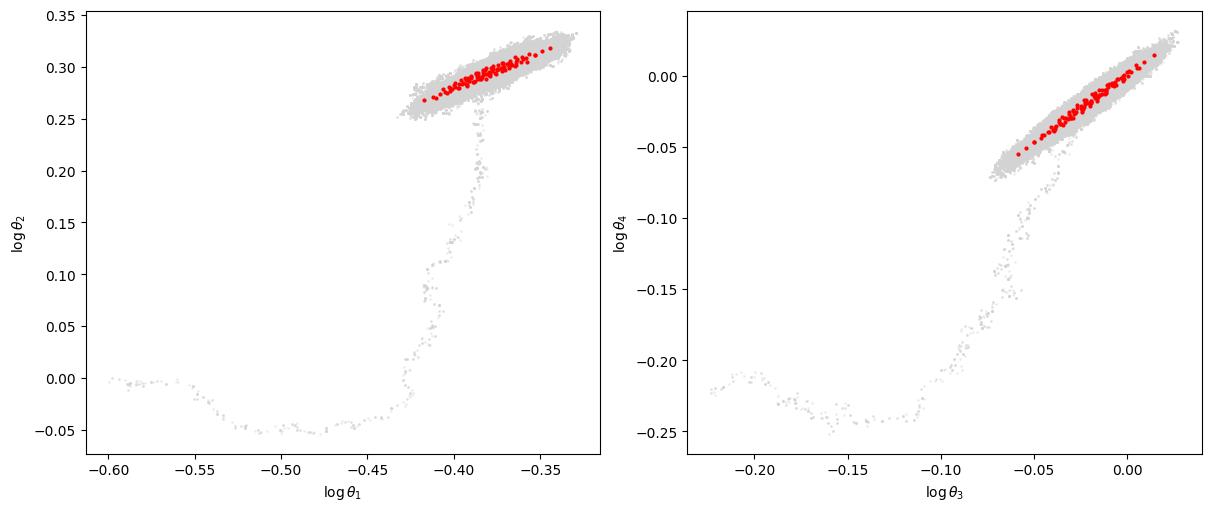

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

In [47]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_gf_t_idx() -> list[np.ndarray]:
    samples = list(rw_samples)
    log_ps = list(rw_log_p)
    t_fits = list(rw_t_fit)
    def calculate(i):
        t_mu, t_scale, t_df = extract_t_params(t_fits[i].x, lotka_volterra.d)
        return thin_gf_t(samples[i], log_ps[i], t_mu, t_scale, t_df, n_points_calculate)
    return map_parallel(calculate, range(len(lotka_volterra.theta_inits)))

In [48]:
#rw_gf_t_idx.recalculate(persist=True);

In [49]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_gf_t2_idx() -> list[np.ndarray]:
    samples = list(rw_samples)
    log_ps = list(rw_log_p)
    def calculate(i):
        sample_mode = samples[i][np.argmax(log_ps[i])]
        sample_cov = np.cov(samples[i], rowvar=False, ddof=lotka_volterra.d)
        return thin_gf_t(samples[i], log_ps[i], sample_mode, sample_cov * 3, 4, n_points_calculate)
    return map_parallel(calculate, range(len(lotka_volterra.theta_inits)))

In [50]:
#rw_gf_t2_idx.recalculate(persist=True);

Notebook execution took:

In [51]:
time.time() - start_time

357.50391817092896

/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.12/site-packages/distributed/system_monitor.py:201: UserWarning: timed out waiting on channel
  self._gilknocker.reset_contention_metric()
